In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#pip install keras-tuner

print(tf.__version__)

2.9.1


In [2]:
def plot_series(time, series, format="-",start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time+phase)%period) / period
    return amplitude*seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

In [3]:
time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
#baselines = 10
amplitude = 20
slope = 0.09
noise_level = 5

In [4]:
# Create series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

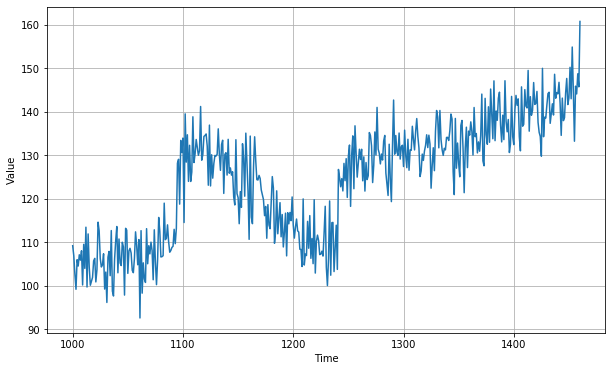

In [5]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for feature, label in dataset.take(1):
    print(feature)
    print(label)

tf.Tensor(
[[ 69.226036    65.11237     83.58645     71.090515    70.93898
   70.82374     72.00993     70.37297     68.30186     68.51139
   71.15755     68.679924    67.90868     72.081055    70.350105
   79.22116     58.52267     77.31149     78.16092     61.640198  ]
 [ 72.793686    68.124916    60.44277     58.784283    65.679634
   56.55721     72.24871     68.916405    60.595913    54.29355
   69.54091     62.10613     68.770195    54.506325    59.374046
   62.28478     62.376335    59.76927     65.00738     56.423985  ]
 [ 99.27729    105.27643     97.177895    94.78875    107.0289
   90.44167     86.7466      99.99983     95.34888     92.81262
  101.52045     99.25781     95.278786    91.758286   102.582954
  101.532776    97.84722    107.63786     93.11605     90.900894  ]
 [ 21.350782    19.015709    23.119297    14.51153     16.129282
   15.553032     9.942256    18.487074    18.058874    16.526875
   15.076769     8.922038    13.645741    13.786459    11.240803
   14.19910

In [8]:
#dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

model.fit(dataset,epochs=100, verbose=0)

In [9]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


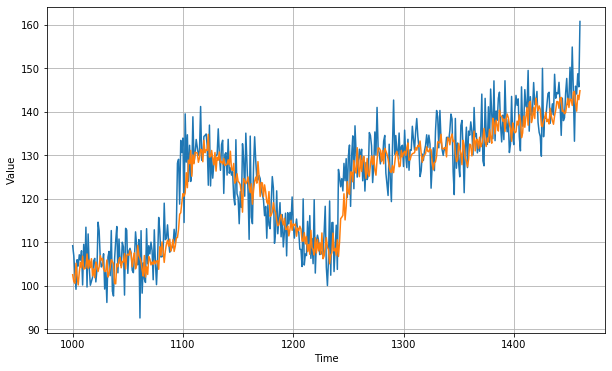

In [10]:
plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

35.353874
4.6667037


In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

[1e-08, 0.001, 0, 300]

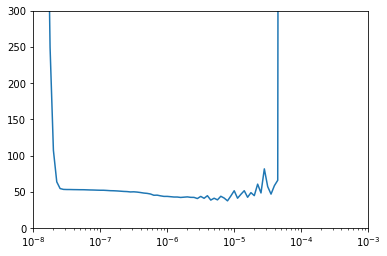

In [14]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [15]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

35.353874
4.6667037


In [16]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=0)

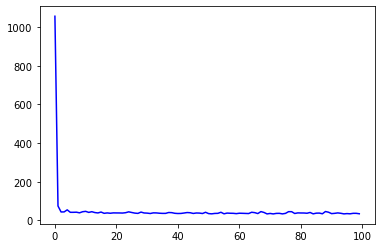

In [17]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[46.53086471557617, 41.08952331542969, 44.708675384521484, 40.26980972290039, 38.29077911376953, 42.935054779052734, 36.35995864868164, 38.39262008666992, 36.70407485961914, 38.567848205566406, 38.30159378051758, 38.152488708496094, 37.716670989990234, 39.57805633544922, 43.999855041503906, 40.58811950683594, 37.40848922729492, 36.012577056884766, 42.71023178100586, 38.155757904052734, 37.40560531616211, 35.3694953918457, 38.670711517333984, 38.37616729736328, 36.81953048706055, 36.006874084472656, 36.0725212097168, 40.501953125, 39.794898986816406, 36.447139739990234, 35.37276840209961, 35.77183532714844, 37.893436431884766, 40.321128845214844, 39.36281967163086, 35.686744689941406, 38.0674934387207, 37.54179382324219, 35.38363265991211, 41.700355529785156, 34.865299224853516, 33.697391510009766, 35.765743255615234, 36.235904693603516, 41.78683853149414, 33.85026168823242, 37.54167175292969, 36.68729019165039, 36.3638801574707, 34.70721435546875, 36.832618713378906, 36.3815803527832, 

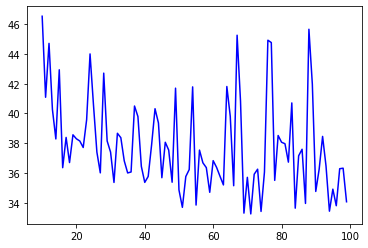

In [18]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [19]:
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,  0, 0]

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


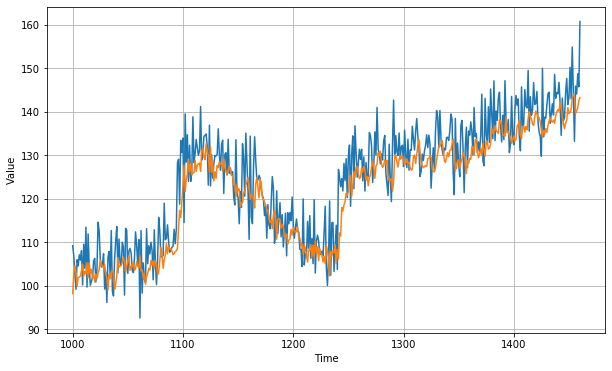

In [20]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

41.28864
5.0101714


In [32]:
#
# Keras Tuner Tool
#

def build_model(hp):
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(units=hp.Int('units',min_value=10, max_value=30, step=2),
                              activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(hp.Choice('learning_rate',
                                                              values=[1e-3, 1e-5, 1e-7]),
                                                    momentum=0.7))
    return model


In [33]:
import keras_tuner as kt

tuner = kt.RandomSearch(build_model,
                    objective='loss', max_trials=150,
                    executions_per_trial=3,
                    directory='my_dir2',
                    project_name='hello2')

tuner.search(dataset, epochs=100, verbose=0)
tuner.results_summary()
tuner.get_best_models(num_models=4)

/home/watson/.local/lib/python3.8/site-packages/keras_tuner/engine/metrics_tracking.py:105: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir2/hello2
Showing 10 best trials
Trial summary
Hyperparameters:
units: 30
learning_rate: 1e-05
Score: 33.955501556396484
Trial summary
Hyperparameters:
units: 28
learning_rate: 1e-05
Score: 34.016424814860024
Trial summary
Hyperparameters:
units: 10
learning_rate: 1e-05
Score: 34.90983327229818
Trial summary
Hyperparameters:
units: 24
learning_rate: 1e-07
Score: 43.55019760131836
Trial summary
Hyperparameters:
units: 22
learning_rate: 1e-07
Score: 50.92266591389974
Trial summary
Hyperparameters:
units: 26
learning_rate: 1e-07
Score: 53.3814951578776
Trial summary
Hyperparameters:
units: 14
learning_rate: 1e-07
Score: 57.60324350992838
Trial summary
Hyperparameters:
units: 20
learning_rate: 1e-07
Score: 57.61921691894531
Trial summary
Hyperparameters:
units: 20
learning_rate: 1e-05
Score: 1051.4805425008137
Trial summary
Hyperparameters:
units: 22
learning_rate: 1e-05
Score: 1051.8331133524578


In [24]:
#
# Keras Tuner Tool
#
'''
def build_model(hp):
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(units=hp.Int('units',min_value=10, max_value=30, step=2),
                              activation="relu", input_shape=[window_size]),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    #optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum',
                                                              values=[0.9, 0.7, 0.5, 0.3]),
                                                    lr=1e-5))
    return model
'''

'\ndef build_model(hp):\n    model = tf.keras.models.Sequential([\n        #tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),\n        tf.keras.layers.Dense(units=hp.Int(\'units\',min_value=10, max_value=30, step=2),\n                              activation="relu", input_shape=[window_size]),\n        tf.keras.layers.Dense(10, activation="relu"),\n        tf.keras.layers.Dense(1)\n    ])\n\n    #optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)\n\n    model.compile(loss="mse",\n                  optimizer=tf.keras.optimizers.SGD(hp.Choice(\'momentum\',\n                                                              values=[0.9, 0.7, 0.5, 0.3]),\n                                                    lr=1e-5))\n    return model\n'

In [25]:
'''
import keras_tuner as kt

tuner = kt.RandomSearch(build_model,
                    objective='loss', max_trials=150,
                    executions_per_trial=3,
                    directory='my_dir',
                    project_name='hello')

tuner.search(dataset, epochs=100, verbose=0)
tuner.results_summary()
tuner.get_best_models(num_models=4)
'''

"\nimport keras_tuner as kt\n\ntuner = kt.RandomSearch(build_model,\n                    objective='loss', max_trials=150,\n                    executions_per_trial=3,\n                    directory='my_dir',\n                    project_name='hello')\n\ntuner.search(dataset, epochs=100, verbose=0)\ntuner.results_summary()\ntuner.get_best_models(num_models=4)\n"

In [26]:
'''
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/hello
Showing 10 best trials
<keras_tuner.engine.objective.Objective object at 0x7fa06baf2520>
Trial summary
Hyperparameters:
units: 24
momentum: 0.5
Score: 34.64320627848307
Trial summary
Hyperparameters:
units: 28
momentum: 0.3
Score: 34.73788833618164
Trial summary
Hyperparameters:
units: 18
momentum: 0.5
Score: 34.93484751383463
Trial summary
Hyperparameters:
units: 26
momentum: 0.3
Score: 35.02076848347982
Trial summary
Hyperparameters:
units: 24
momentum: 0.7
Score: 35.09748331705729
Trial summary
Hyperparameters:
units: 20
momentum: 0.7
Score: 35.17549514770508
Trial summary
Hyperparameters:
units: 24
momentum: 0.9
Score: 35.25161488850912
Trial summary
Hyperparameters:
units: 16
momentum: 0.3
Score: 35.326281229654946
Trial summary
Hyperparameters:
units: 22
momentum: 0.9
Score: 35.42705281575521
Trial summary
Hyperparameters:
units: 28
momentum: 0.9
Score: 35.58544667561849
'''

'\nINFO:tensorflow:Oracle triggered exit\nResults summary\nResults in my_dir/hello\nShowing 10 best trials\n<keras_tuner.engine.objective.Objective object at 0x7fa06baf2520>\nTrial summary\nHyperparameters:\nunits: 24\nmomentum: 0.5\nScore: 34.64320627848307\nTrial summary\nHyperparameters:\nunits: 28\nmomentum: 0.3\nScore: 34.73788833618164\nTrial summary\nHyperparameters:\nunits: 18\nmomentum: 0.5\nScore: 34.93484751383463\nTrial summary\nHyperparameters:\nunits: 26\nmomentum: 0.3\nScore: 35.02076848347982\nTrial summary\nHyperparameters:\nunits: 24\nmomentum: 0.7\nScore: 35.09748331705729\nTrial summary\nHyperparameters:\nunits: 20\nmomentum: 0.7\nScore: 35.17549514770508\nTrial summary\nHyperparameters:\nunits: 24\nmomentum: 0.9\nScore: 35.25161488850912\nTrial summary\nHyperparameters:\nunits: 16\nmomentum: 0.3\nScore: 35.326281229654946\nTrial summary\nHyperparameters:\nunits: 22\nmomentum: 0.9\nScore: 35.42705281575521\nTrial summary\nHyperparameters:\nunits: 28\nmomentum: 0.9\n